# Imports
### General imports

In [1]:
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import numpy as np
import pandas as pd

### Regressors imports

In [2]:
from sklearn.linear_model import LinearRegression as LM
from sklearn.linear_model import RidgeCV as Ridge
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neighbors import RadiusNeighborsRegressor as radNN
from sklearn.ensemble import ExtraTreesRegressor as ET
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as Ada
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as ANN

In [28]:
reg = {'LM':LM(),
#      'Ridge':Ridge(),
      'KNN':KNN(),
#      'radNN':radNN(radius=200),
      'DT':DT(),
      'ET':ET(n_estimators=100, random_state=0),
      'RF':RF(),
#      'Ada':Ada(),
#      'SVM':SVR(),
      'ANN':ANN(hidden_layer_sizes=(50,),max_iter=400,random_state=42) #hidden_layer_sizes=(50,),max_iter=400,random_state=42
      } #shuffle=False,

### Assesment metrics

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

from wikipedia:
There are cases where the computational definition of R2 can yield negative values, depending on the definition used. This can arise when the predictions that are being compared to the corresponding outcomes have not been derived from a model-fitting procedure using those data. Even if a model-fitting procedure has been used, R2 may still be negative, for example when linear regression is conducted without including an intercept,[5] or when a non-linear function is used to fit the data.[6] **In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion**.

# Data Loading

In [5]:
tsla_price = pickle.load(open("../data/data_h_corrected.pickle","rb"))['Open']
tsla_trend = pickle.load(open("../data/GT_tsla_h.pickle","rb"))
musk_trend = pickle.load(open("../data/GT_musk_h.pickle","rb"))
musk_twitter = pickle.load(open("../data/twitter_musk_h.pickle","rb"))
musk_tesla_twitter = pickle.load(open("../data/twitter_musk_tesla_h.pickle","rb"))

In [16]:
print(type(musk_twitter.index))
print(type(musk_tesla_twitter.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [6]:
start_ts = tsla_price.index[0]
end_ts = tsla_price.index[-1]
tsla_trend = tsla_trend[start_ts:end_ts]
musk_trend = musk_trend[start_ts:end_ts]
#musk_twitter = musk_twitter[start_ts:end_ts]
musk_tesla_twitter = musk_tesla_twitter[start_ts:end_ts]
data = pd.concat([tsla_price,tsla_trend,musk_trend,musk_tesla_twitter],axis=1)
#need to replace NAN in the musk_tesla_twitter columns with zero, or the later step of removing NAN rows will delete stuff I don't want
#to delete. This is because I didn't preprocess the musk_tesla_twitter data the same way as the musk_twitter
data[["like_count","retweet_count","reply_count","quote_count"]] = data[["like_count","retweet_count","reply_count","quote_count"]].fillna(0)
print(data.head(10))

                          Open  tsla  musk  like_count  retweet_count  \
2019-02-11 10:00:00  62.349998  1.62  3.36     71095.0         4636.0   
2019-02-11 11:00:00  63.153004  2.61   3.5         0.0            0.0   
2019-02-11 12:00:00  62.935997  4.23  3.64         0.0            0.0   
2019-02-11 13:00:00  63.230000  5.49  3.71         0.0            0.0   
2019-02-11 14:00:00  62.996002  8.46  3.92         0.0            0.0   
2019-02-11 15:00:00  62.826836   9.0  4.13         0.0            0.0   
2019-02-11 16:00:00  62.770000  7.92  4.34         0.0            0.0   
2019-02-11 17:00:00        NaN  7.65  4.62         0.0            0.0   
2019-02-11 18:00:00        NaN  7.74   4.9         0.0            0.0   
2019-02-11 19:00:00        NaN  7.74  5.04         0.0            0.0   

                     reply_count  quote_count  
2019-02-11 10:00:00       2820.0        485.0  
2019-02-11 11:00:00          0.0          0.0  
2019-02-11 12:00:00          0.0          0.0  
2019

Note to self: there are only 7 hours of prices every working day, whereas there is trend data for every hour of every day... I should keep this in mind, and be wary as it might cause a problem later...

# Cut date for training/test set

In [7]:
cut_date = dt.datetime(year=2021,month=1,day=4,hour=10) # For now just testing various cut point around 2 month
print('cut date = ',cut_date)
#print(pd.Timestamp(cut_date))
#cut_idx = tsla_price.index[tsla_price.index == pd.Timestamp(cut_date)].values[0]
#print('cut index = ',cut_idx)

cut date =  2021-01-04 10:00:00


# Auxilary functions
### Split data

In [8]:
def split_data(data,cut_idx):
    train = data[:cut_idx]
    test = data[cut_idx:]
    return train, test

### Converting from original to log returns and back functions

In [9]:
def convert_to_logret(stock_price):
    initial = stock_price.iloc[0]
    returns = 100*(np.log(stock_price)).diff()
    return returns, initial

def convert_from_logret(returns,initial,axis=0):
    stock_price = np.exp((returns/100).cumsum(axis)) * initial
    return stock_price

### Plot Prediction function

In [10]:
def plot_predict(stock_train,stock_test,stock_predict):
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    axs[0].plot(stock_train)
    axs[0].plot(stock_test)
    axs[0].plot(stock_predict)

    axs[1].plot(stock_train[-300:])
    axs[1].plot(stock_test)
    axs[1].plot(stock_predict)
    return


#y_test_true = response[cut_idx:-35*4]
#x_test = features[cut_idx:-35*4]
#y_test = dectree_v2.predict(x_test)

#y_train_os = np.exp((response[:cut_idx]/100).cumsum()+np.log(tsla['Open'].iloc[0]))
#offset = ((response[:cut_idx]/100).cumsum()+np.log(tsla['Open'].iloc[0])).iloc[-1,0]
#print(np.exp(offset))
#y_test_os = np.exp((y_test/100).cumsum(1)+offset)
#y_test_true_os = np.exp((y_test_true/100).cumsum(1)+offset)



# Features and responses

In [11]:
time = pd.Series(data=range(len(tsla_trend)),index=tsla_trend.index)
data['time'] = time
returns, initial = convert_to_logret(tsla_price)
data['returns'] = returns
print(data.head(20))
data.dropna(inplace=True)
print(data.head(20))

                          Open  tsla  musk  like_count  retweet_count  \
2019-02-11 10:00:00  62.349998  1.62  3.36     71095.0         4636.0   
2019-02-11 11:00:00  63.153004  2.61   3.5         0.0            0.0   
2019-02-11 12:00:00  62.935997  4.23  3.64         0.0            0.0   
2019-02-11 13:00:00  63.230000  5.49  3.71         0.0            0.0   
2019-02-11 14:00:00  62.996002  8.46  3.92         0.0            0.0   
2019-02-11 15:00:00  62.826836   9.0  4.13         0.0            0.0   
2019-02-11 16:00:00  62.770000  7.92  4.34         0.0            0.0   
2019-02-11 17:00:00        NaN  7.65  4.62         0.0            0.0   
2019-02-11 18:00:00        NaN  7.74   4.9         0.0            0.0   
2019-02-11 19:00:00        NaN  7.74  5.04         0.0            0.0   
2019-02-11 20:00:00        NaN  7.92  5.53         0.0            0.0   
2019-02-11 21:00:00        NaN  7.83  5.32         0.0            0.0   
2019-02-11 22:00:00        NaN  6.48  5.74         

# price shifting

In [12]:
def shift(df,column,list_shifts):
    for i in list_shifts:
        name = column + str(-i)
        df[name]=df[column].shift(i)
    return df

In [13]:
data = shift(data,'returns',range(-35*4+1,35*4+1))
data = shift(data,'tsla',range(1,35*4+1))
data = shift(data,'musk',range(1,35*4+1))
data = shift(data,'like_count',range(1,35*4+1))
data = shift(data,'retweet_count',range(1,35*4+1))
data = data.dropna()

In [26]:
print(data.head())

                          Open   tsla  musk  like_count  retweet_count  \
2019-03-12 11:00:00  56.785999    8.4   2.8         0.0            0.0   
2019-03-12 12:00:00  56.437542  11.04   2.8         0.0            0.0   
2019-03-12 13:00:00  56.417999  14.16  3.12         0.0            0.0   
2019-03-12 14:00:00  56.757141   15.6  3.04         0.0            0.0   
2019-03-12 15:00:00  56.629997   15.6  3.12         0.0            0.0   

                     reply_count  quote_count  time   returns  returns139  \
2019-03-12 11:00:00          0.0          0.0   701 -0.831247   -0.992845   
2019-03-12 12:00:00          0.0          0.0   702 -0.615523    0.875030   
2019-03-12 13:00:00          0.0          0.0   703 -0.034633   -0.489179   
2019-03-12 14:00:00          0.0          0.0   704  0.599324    0.515817   
2019-03-12 15:00:00          0.0          0.0   705 -0.224265   -0.383862   

                     ...  retweet_count-131  retweet_count-132  \
2019-03-12 11:00:00  ...  

In [14]:
f_list = ['tsla','musk','time']
f_list2 = f_list + ['returns'+str(i) for i in range(-35*4,0)]
features = data[f_list]
features2 = data[f_list2]
response = data[['returns']]
response2 = data[['returns']+['returns'+str(i) for i in range(1,35*4)]]
print(features2)
print(response2)

                     returns-140  returns-139  returns-138  returns-137  \
2019-03-12 11:00:00     1.279676    -0.344212     0.466058    -0.370760   
2019-03-12 12:00:00    -0.344212     0.466058    -0.370760    -0.268897   
2019-03-12 13:00:00     0.466058    -0.370760    -0.268897    -0.090504   
2019-03-12 14:00:00    -0.370760    -0.268897    -0.090504     0.730161   
2019-03-12 15:00:00    -0.268897    -0.090504     0.730161    -0.415223   
...                          ...          ...          ...          ...   
2021-01-12 12:00:00     0.487020    -0.257728    -1.091743    -0.396694   
2021-01-12 13:00:00    -0.257728    -1.091743    -0.396694    -1.077729   
2021-01-12 14:00:00    -1.091743    -0.396694    -1.077729     0.441336   
2021-01-12 15:00:00    -0.396694    -1.077729     0.441336     0.426521   
2021-01-12 16:00:00    -1.077729     0.441336     0.426521     0.124704   

                     returns-136  returns-135  returns-134  returns-133  \
2019-03-12 11:00:00    -

# training

In [15]:
#cut_idx = tsla_price.reset_index().index[tsla_price.index == pd.Timestamp(cut_date)].values[0]
cut_idx = pd.Timestamp(cut_date)
#print('cut index = ',cut_idx)

x_train, x_test = split_data(features,cut_idx)
y_train, y_test = split_data(response,cut_idx)
x2_train, x2_test = split_data(features2,cut_idx)
y2_train, y2_test = split_data(response2,cut_idx)
x2_train = x2_train[:-35*4]
y2_train = y2_train[:-35*4]

#print(x_train)
#print(x_test)
print(y_train)
#print(y_test)

                      returns
2019-03-12 11:00:00 -0.831247
2019-03-12 12:00:00 -0.615523
2019-03-12 13:00:00 -0.034633
2019-03-12 14:00:00  0.599324
2019-03-12 15:00:00 -0.224265
...                       ...
2020-12-31 13:00:00 -0.054423
2020-12-31 14:00:00  0.026473
2020-12-31 15:00:00 -0.979709
2020-12-31 16:00:00 -1.436686
2021-01-04 10:00:00  2.999080

[3190 rows x 1 columns]


# fitting the models

In [16]:
#reg['LM'].fit(x_train,y_train)
for model in reg:
    reg[model].fit(x_train,y_train['returns'])

# Prediction

LM


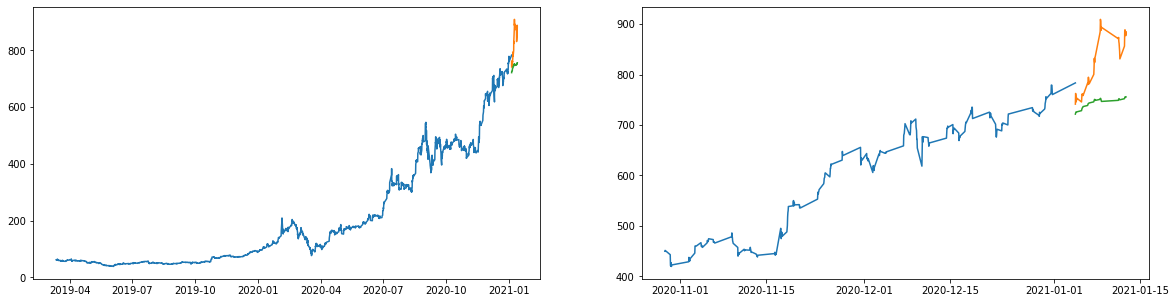

Ridge


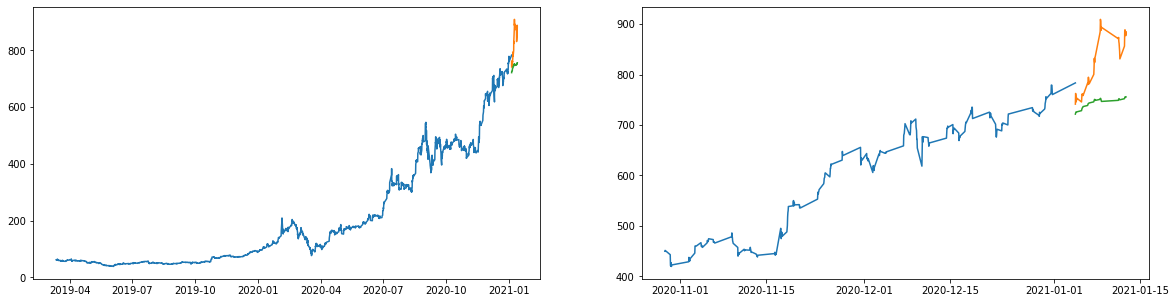

KNN


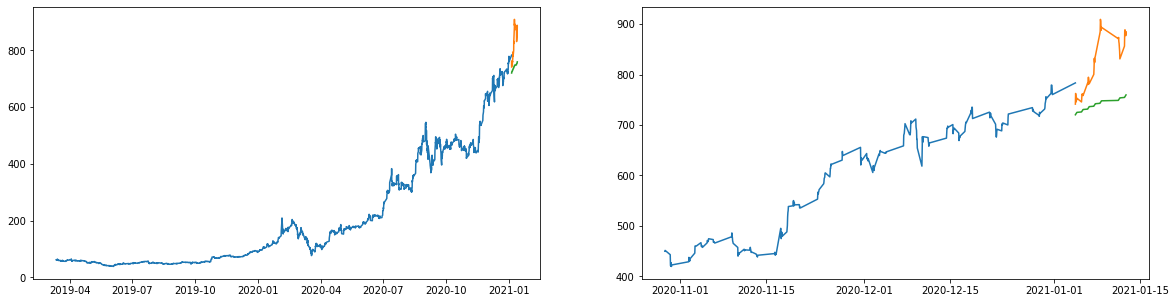

DT


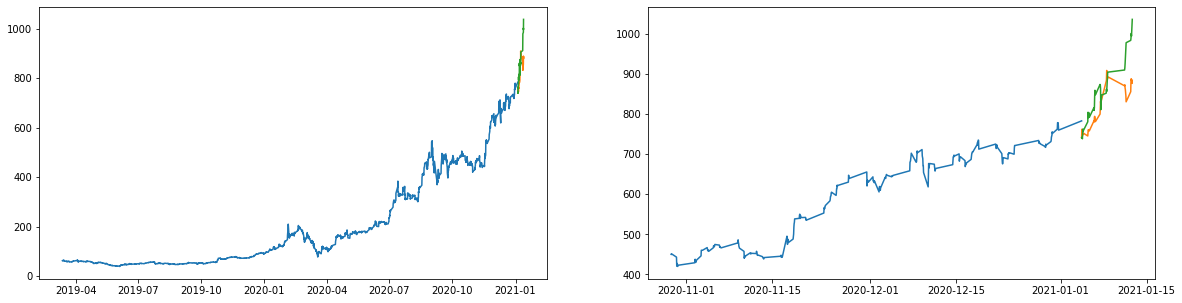

ET


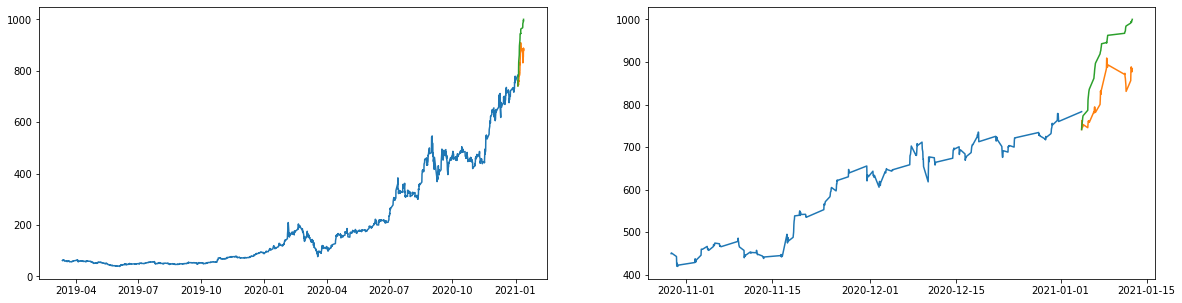

RF


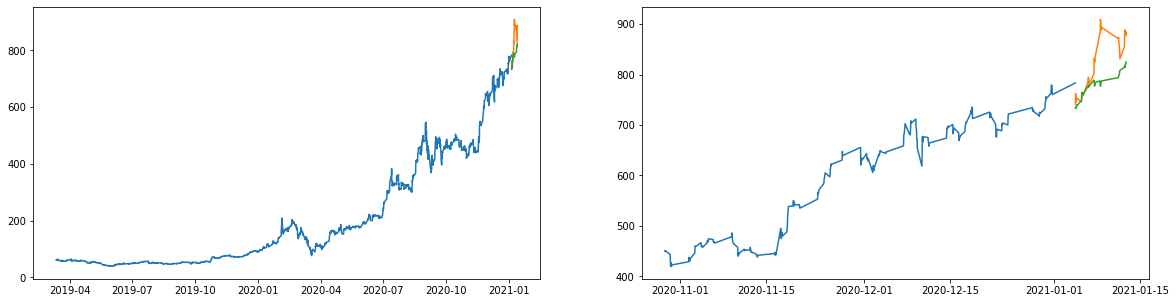

Ada


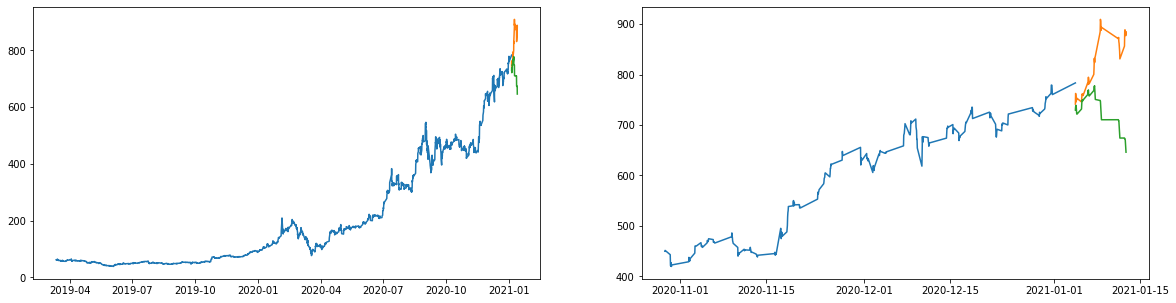

ANN


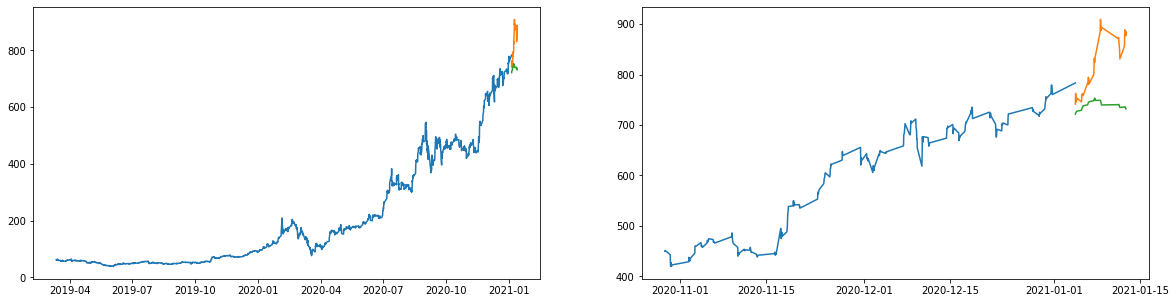

In [17]:
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2"])
for model in reg:
    print(model)
    y_predict = reg[model].predict(x_test)
    y_predict = pd.DataFrame(y_predict, index=x_test.index)
    y_train_os = convert_from_logret(y_train,initial,axis=0)
    y_test_os = convert_from_logret(y_test,data.loc[cut_idx,'Open'],axis=0)
    y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=0)
    #plot_predict(y_train,y_test,y_predict)
    plot_predict(y_train_os,y_test_os,y_predict_os)
    plt.show()
    
    metrics["MSE"][model] = mean_squared_error(y_test, y_predict)
    metrics["R2"][model] = r2_score(y_test,y_predict)

# Assesment

In [18]:
print("mean square error : ",mean_squared_error(y_test, y_predict))
print("R2 : ",r2_score(y_test,y_predict))

print(metrics)

mean square error :  2.443260568425965
R2 :  0.0010748422490278742
            MSE        R2
LM     2.363438   0.03371
Ridge  2.363442  0.033709
KNN    2.542409 -0.039462
DT     4.437046 -0.814083
ET     2.289933  0.063763
RF     2.335849   0.04499
Ada    2.662253  -0.08846
ANN    2.443261  0.001075


# Part 2

In [19]:
#reg['KNN'].fit(x2_train,y2_train)
for model in reg:
    reg[model].fit(x2_train,y2_train)

ValueError: y should be a 1d array, got an array of shape (3050, 140) instead.

LM


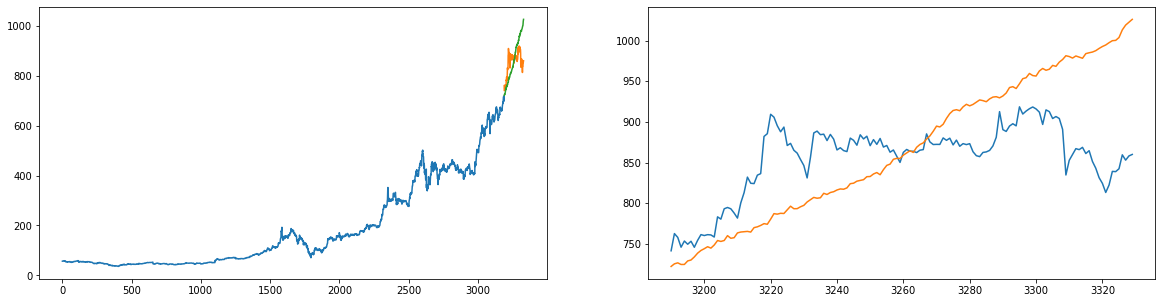

Ridge


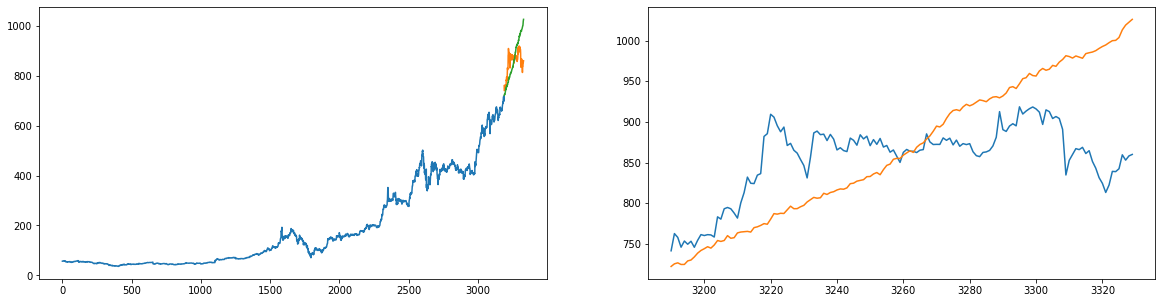

KNN


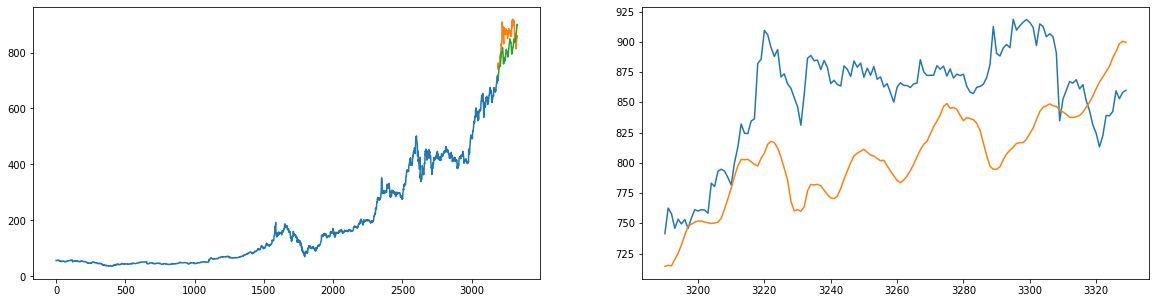

DT


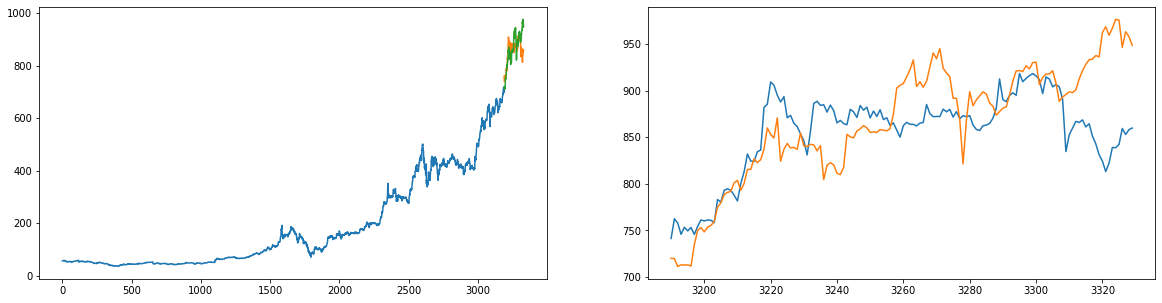

ET


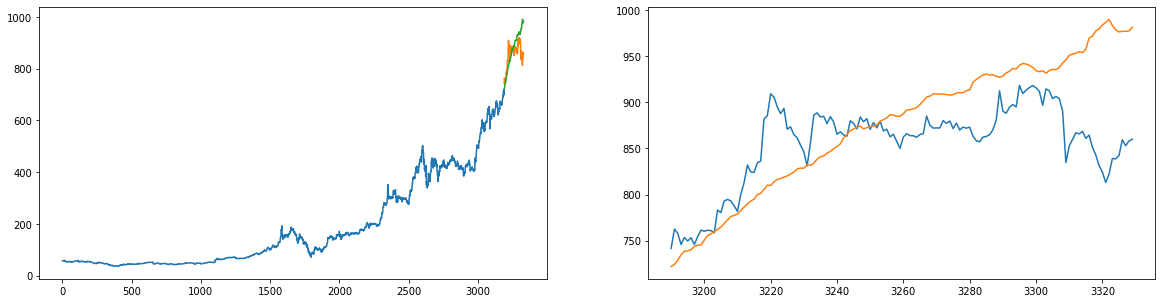

ANN


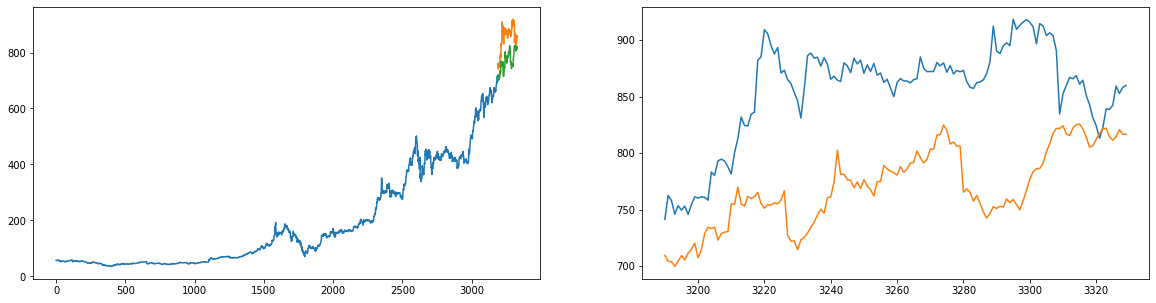

            MSE        R2 MSE_original_scale R2_original_scale
LM      1.97216 -0.041563        5611.508592          -1.87074
Ridge   1.97195 -0.041451        5610.691186         -1.870322
KNN    2.091144 -0.104402        4031.657174         -1.062518
DT     4.175372 -1.205151        2365.611784         -0.210202
ET     2.003438 -0.058082         3507.24044         -0.794237
ANN    3.352576 -0.770605        8950.910832         -3.579114


In [177]:
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])
for model in reg: ####### reg
    print(model)
    y2_predict = reg[model].predict(x2_test)
    y2_predict = pd.DataFrame(y2_predict, index=x2_test.index)
    
    iidx = pd.Timestamp(pd.to_datetime(y2_train.index[0])+dt.timedelta(hours=-1))
    #print(iidx)
    initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    #print(initial)
    
    y2_train_os = convert_from_logret(y2_train,initial)
    y2_test_os = convert_from_logret(y2_test,data['Open'][cut_idx],axis=1)
    y2_predict_os = convert_from_logret(y2_predict,data['Open'][cut_idx],axis=1)
    #plot_predict(y_train,y_test,y_predict)
    #plot_predict(y_train_os,y_test_os.iloc[0],y_predict_os.iloc[0])
    #print(x2_train)
    #plt.show()
    
    
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    #n_train = len(y2_train_os['returns'])
    n_train = len(data['Open'][:cut_idx])
    n_test = len(y2_test_os.iloc[0])

    axs[0].plot(range(n_train),data['Open'][:cut_idx])
    axs[0].plot(range(n_train,n_train+n_test),y2_test_os.iloc[0])
    axs[0].plot(range(n_train,n_train+n_test),y2_predict_os.iloc[0])
    #axs[0].plot(range(3050+140-92),tsla_price.iloc[140:-140])



    #axs[1].plot(range(n_train-300,n_train),data['Open'][:cut_idx][-300:])
    axs[1].plot(range(n_train,n_train+n_test),y2_test_os.iloc[0])
    axs[1].plot(range(n_train,n_train+n_test),y2_predict_os.iloc[0])
    #axs[1].plot(range(2750+140-92,3050+280-92),tsla_price.iloc[-440:])

    plt.show()
    
    metrics["MSE"][model] = mean_squared_error(y2_test.iloc[0], y2_predict.iloc[0])
    metrics["R2"][model] = r2_score(y2_test.iloc[0],y2_predict.iloc[0])
    metrics["MSE_original_scale"][model] = mean_squared_error(y2_test_os.iloc[0],y2_predict_os.iloc[0])
    metrics["R2_original_scale"][model] = r2_score(y2_test_os.iloc[0],y2_predict_os.iloc[0])

print(metrics)
    
    

# Using one month to predict one week ahead

In [178]:
x3_train = x2_train[:-35]
y3_train = y2_train[['returns']+['returns'+str(i) for i in range(1,35)]][:-35]

In [40]:
#print(x2_train.head())
#print(y3_train.head())

In [179]:
for model in reg:
    reg[model].fit(x3_train,y3_train)

LM


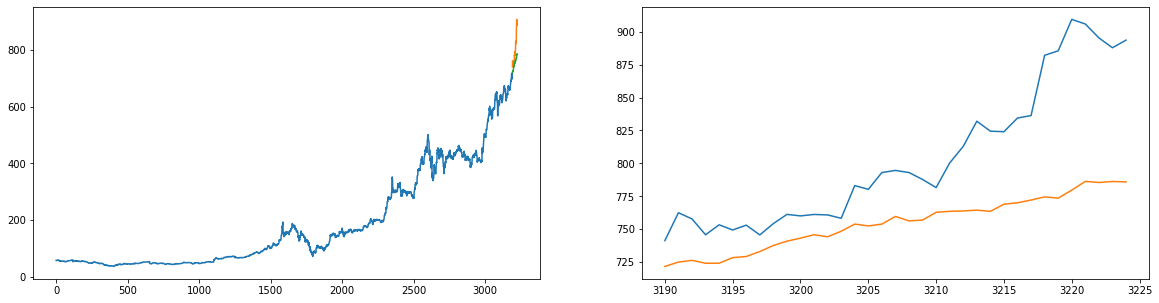

Ridge


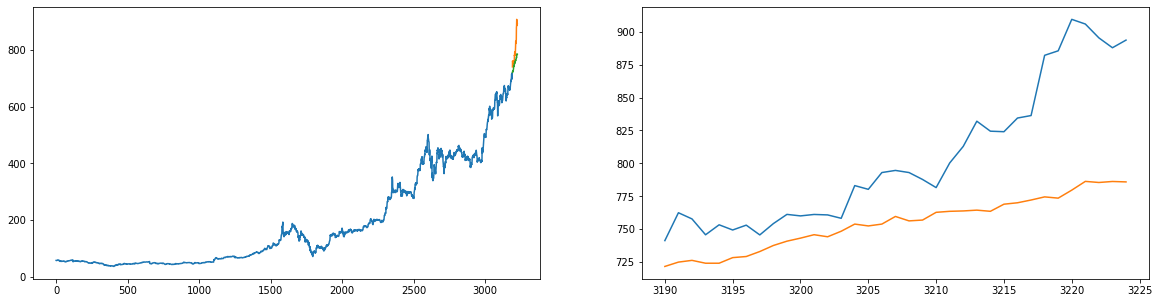

KNN


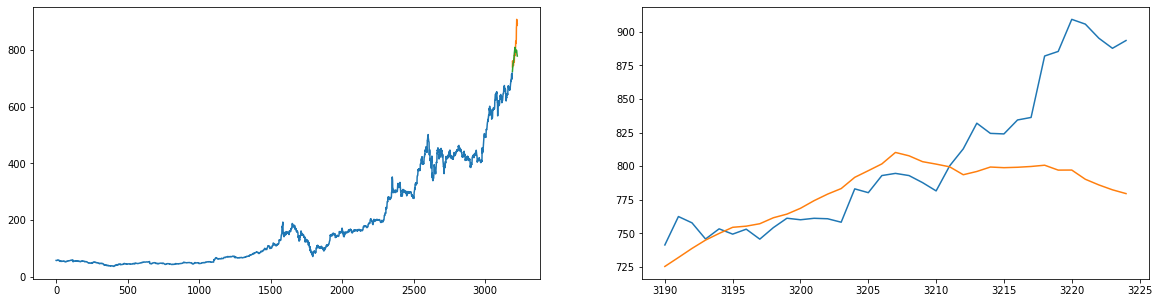

DT


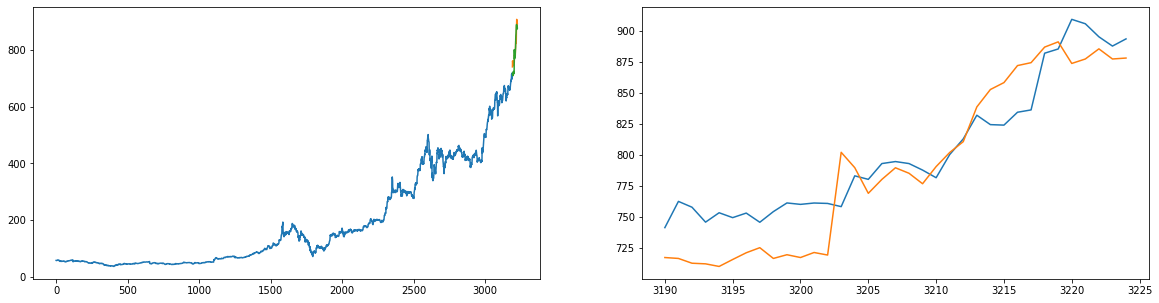

ET


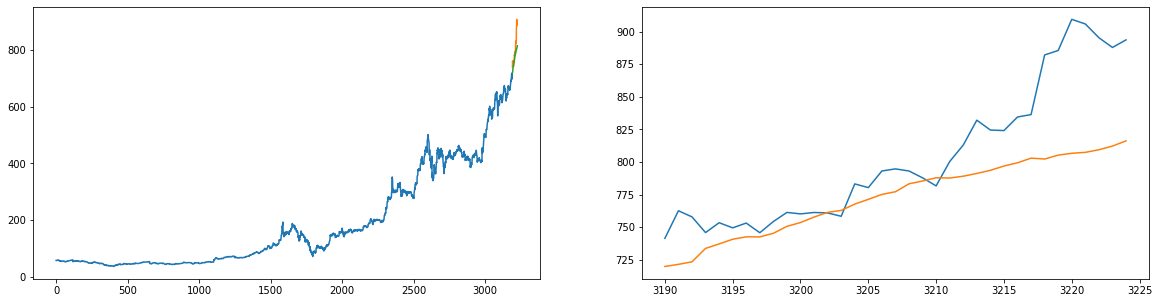

ANN


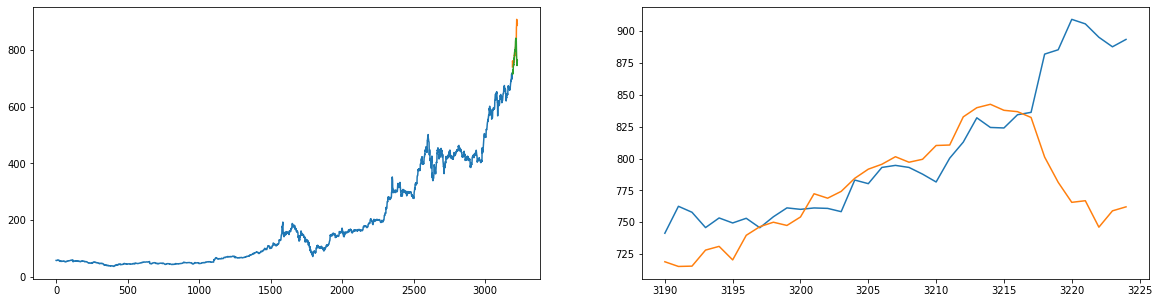

            MSE        R2 MSE_original_scale R2_original_scale
LM     2.312941 -0.016064        3608.585651         -0.288872
Ridge  2.312922 -0.016056        3607.995406         -0.288661
KNN    2.465033 -0.082877        2468.557369           0.11831
DT     7.074975 -2.108004          819.37731          0.707344
ET      2.70363 -0.187692        1826.789094          0.347529
ANN     5.70461 -1.506008        3508.431446           -0.2531


In [180]:
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])
for model in reg: ####### reg
    print(model)
    y3_predict = reg[model].predict(x2_test)
    y3_predict = pd.DataFrame(y3_predict, index=x2_test.index)
    
    iidx = pd.Timestamp(pd.to_datetime(y3_train.index[0])+dt.timedelta(hours=-1))
    #print(iidx)
    initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    #print(initial)
    
    y3_test = y2_test[['returns']+['returns'+str(i) for i in range(1,35)]]
    
    y3_train_os = convert_from_logret(y3_train,initial)
    y3_test_os = convert_from_logret(y3_test,data['Open'][cut_idx],axis=1)
    y3_predict_os = convert_from_logret(y3_predict,data['Open'][cut_idx],axis=1)
    #plot_predict(y_train,y_test,y_predict)
    #plot_predict(y_train_os,y_test_os.iloc[0],y_predict_os.iloc[0])
    #print(x2_train)
    #plt.show()
    
    
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    #n_train = len(y2_train_os['returns'])
    n_train = len(data['Open'][:cut_idx])
    n_test = len(y3_test_os.iloc[0])

    axs[0].plot(range(n_train),data['Open'][:cut_idx])
    axs[0].plot(range(n_train,n_train+n_test),y3_test_os.iloc[0])
    axs[0].plot(range(n_train,n_train+n_test),y3_predict_os.iloc[0])
    #axs[0].plot(range(3050+140-92),tsla_price.iloc[140:-140])



    #axs[1].plot(range(n_train-300,n_train),data['Open'][:cut_idx][-300:])
    axs[1].plot(range(n_train,n_train+n_test),y3_test_os.iloc[0])
    axs[1].plot(range(n_train,n_train+n_test),y3_predict_os.iloc[0])
    #axs[1].plot(range(2750+140-92,3050+280-92),tsla_price.iloc[-440:])

    plt.show()
    
    metrics["MSE"][model] = mean_squared_error(y3_test.iloc[0], y3_predict.iloc[0])
    metrics["R2"][model] = r2_score(y3_test.iloc[0],y3_predict.iloc[0])
    metrics["MSE_original_scale"][model] = mean_squared_error(y3_test_os.iloc[0],y3_predict_os.iloc[0])
    metrics["R2_original_scale"][model] = r2_score(y3_test_os.iloc[0],y3_predict_os.iloc[0])

print(metrics)

# making the code more robust

In [26]:
forward_timesteps = 35 #one week
backward_timesteps = -35*4 #four weeks

stock_variables = ["returns"]+['returns'+str(i) for i in range(backward_timesteps,0)]
g_trend_variables = ["tsla","musk"]+['tsla'+str(i) for i in range(backward_timesteps,0)]#+['musk'+str(i) for i in range(backward_timesteps,0)]
twitter_variables = [] + ["retweet_count"]+['retweet_count'+str(i) for i in range(backward_timesteps,0)]#+ ["like_count"]+['like_count'+str(i) for i in range(backward_timesteps,0)]

feature_list = stock_variables + g_trend_variables + twitter_variables + ["time"]
response_list = ["returns"]+['returns'+str(i) for i in range(1,forward_timesteps)]

features = data[feature_list]
responses = data[response_list]

cut_idx = pd.Timestamp(cut_date)

x_train, x_test = split_data(features,cut_idx)
y_train, y_test = split_data(responses,cut_idx)

#correction for overlapping features and responses:
x_train = x_train[:-forward_timesteps]
y_train = y_train[:-forward_timesteps]
    
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])

In [29]:
for model in reg:
    reg[model].fit(x_train,y_train)

LM


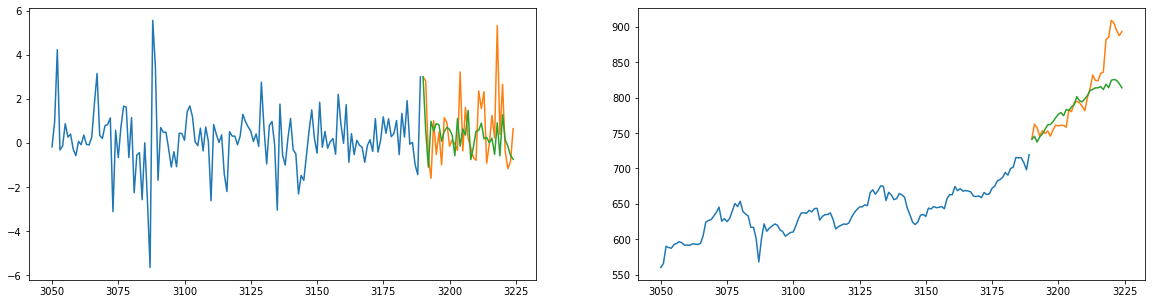

KNN


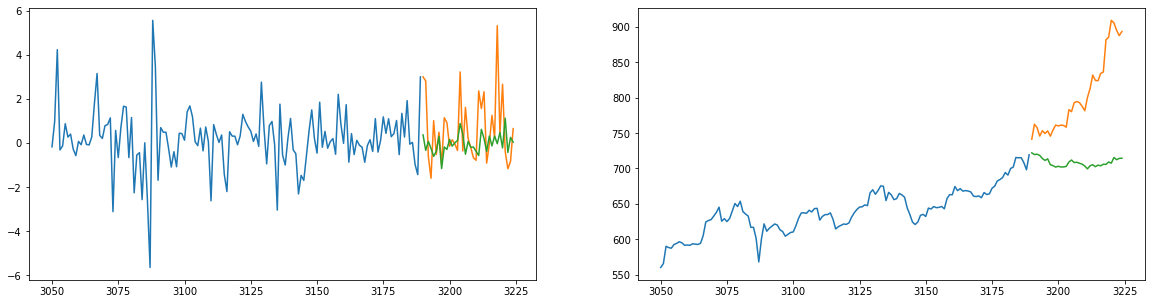

DT


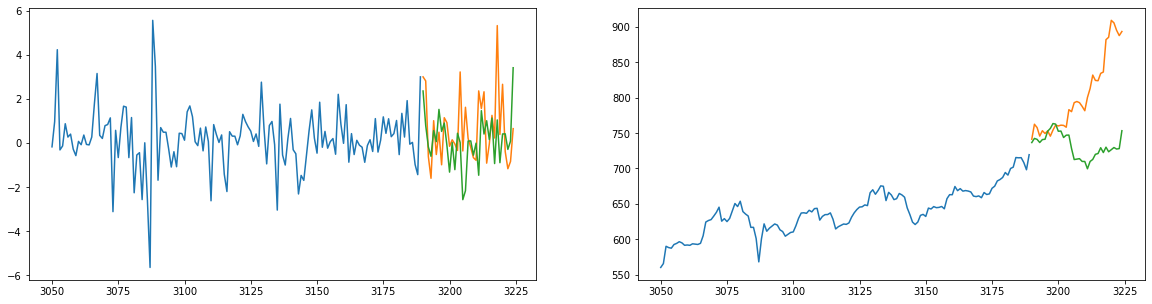

ET


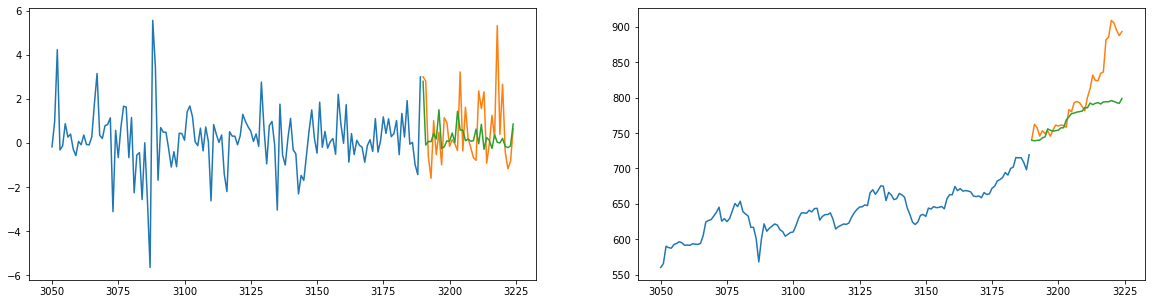

RF


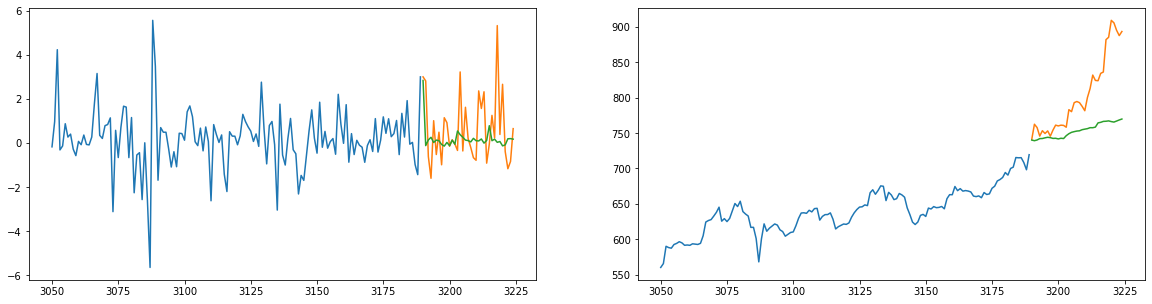

ANN


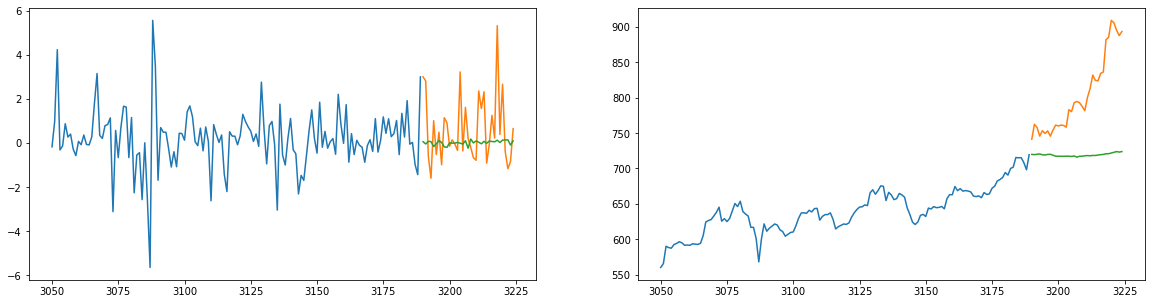

          MSE        R2 MSE_original_scale R2_original_scale
LM   2.102195  0.076515        1238.834902          0.557528
KNN  2.694193 -0.183546       11733.935778         -3.190989
DT   2.931739 -0.287899        8681.904986         -2.100901
ET   2.432195 -0.068452        2285.391069          0.183731
RF   2.440409  -0.07206        4371.600032         -0.561397
Ada       NaN       NaN                NaN               NaN
ANN  2.634509 -0.157327        9670.280087         -2.453917


In [30]:
for model in reg:
    print(model)
    
    y_predict = reg[model].predict(x_test)
    y_predict = pd.DataFrame(y_predict, index=x_test.index)
    
    #we need the initial stock price to transforme the returns back into the real price
    iidx = pd.Timestamp(pd.to_datetime(y_train.index[0])+dt.timedelta(hours=-1))
    initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    
    #change the returns back to the price (os=original scale)
    y_train_os = convert_from_logret(y_train,initial)
    y_test_os = convert_from_logret(y_test,data['Open'][cut_idx],axis=1)
    y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=1)
    
    
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    #n_train = len(y2_train_os['returns'])
    n_train = len(data['Open'][:cut_idx])
    n_test = len(y_test_os.iloc[0])
    #print(n_train, n_test, backward_timesteps)

    axs[0].plot(range(n_train+backward_timesteps,n_train),data['returns'][:cut_idx][backward_timesteps:])
    axs[0].plot(range(n_train,n_train+n_test),y_test.iloc[0])
    axs[0].plot(range(n_train,n_train+n_test),y_predict.iloc[0])

    axs[1].plot(range(n_train+backward_timesteps,n_train),data['Open'][:cut_idx][backward_timesteps:])
    axs[1].plot(range(n_train,n_train+n_test),y_test_os.iloc[0])
    axs[1].plot(range(n_train,n_train+n_test),y_predict_os.iloc[0])

    plt.show()
    
    metrics["MSE"][model] = mean_squared_error(y_test.iloc[0], y_predict.iloc[0])
    metrics["R2"][model] = r2_score(y_test.iloc[0],y_predict.iloc[0])
    metrics["MSE_original_scale"][model] = mean_squared_error(y_test_os.iloc[0],y_predict_os.iloc[0])
    metrics["R2_original_scale"][model] = r2_score(y_test_os.iloc[0],y_predict_os.iloc[0])
    
print(metrics)

# -------------------------------------------------------------------------

In [23]:
model='ANN'
reg[model].fit(x_train,y_train)
y_predict_temp = reg[model].predict(x_test)
y_predict = pd.DataFrame(1/50*y_predict_temp, index=x_test.index)

for i in range(50):
    reg['ANN'].fit(x_train,y_train)
    y_predict_temp = reg[model].predict(x_test)
    y_predict = y_predict.add(pd.DataFrame(1/50*y_predict_temp, index=x_test.index))

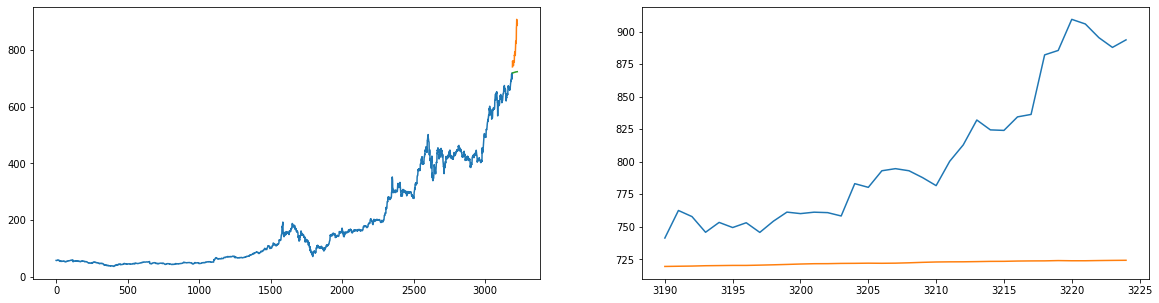

          MSE        R2 MSE_original_scale R2_original_scale
LM   2.102195  0.076515        1238.834902          0.557528
KNN  2.694193 -0.183546       11733.935778         -3.190989
DT   2.931739 -0.287899        8681.904986         -2.100901
ET   2.432195 -0.068452        2285.391069          0.183731
ANN  2.656539 -0.167005        9180.910453         -2.279129


In [24]:
#we need the initial stock price to transforme the returns back into the real price
iidx = pd.Timestamp(pd.to_datetime(y_train.index[0])+dt.timedelta(hours=-1))
initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    
#change the returns back to the price (os=original scale)
y_train_os = convert_from_logret(y_train,initial)
y_test_os = convert_from_logret(y_test,data['Open'][cut_idx],axis=1)
y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=1)
    
fig, axs =plt.subplots(1,2,figsize=(20,5))

#n_train = len(y2_train_os['returns'])
n_train = len(data['Open'][:cut_idx])
n_test = len(y_test_os.iloc[0])

axs[0].plot(range(n_train),data['Open'][:cut_idx])
axs[0].plot(range(n_train,n_train+n_test),y_test_os.iloc[0])
axs[0].plot(range(n_train,n_train+n_test),y_predict_os.iloc[0])

#axs[1].plot(range(n_train-backward_timesteps,n_train),data['Open'][:cut_idx][-backward_timesteps:])
axs[1].plot(range(n_train,n_train+n_test),y_test_os.iloc[0])
axs[1].plot(range(n_train,n_train+n_test),y_predict_os.iloc[0])

plt.show()
    
metrics["MSE"][model] = mean_squared_error(y_test.iloc[0], y_predict.iloc[0])
metrics["R2"][model] = r2_score(y_test.iloc[0],y_predict.iloc[0])
metrics["MSE_original_scale"][model] = mean_squared_error(y_test_os.iloc[0],y_predict_os.iloc[0])
metrics["R2_original_scale"][model] = r2_score(y_test_os.iloc[0],y_predict_os.iloc[0])
    
print(metrics)